In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessClassifier
import torch
import gpytorch

from utils import *
pd.set_option('display.max_columns', None)

In [2]:
results_list = []
pred_list = []
data_train_raw = pd.read_csv('data_train_full.csv')
data_test_raw = pd.read_csv('data_test.csv')

precision = True
print_results = True

In [3]:
# Preprocessing
y_train_cat = data_train_raw['category'].to_numpy()
y_test_cat = data_test_raw['category'].to_numpy()
le = LabelEncoder()
le.fit(y_train_cat)
y_train = le.transform(y_train_cat)
y_test = le.transform(y_test_cat)
X_train = encode(data_train_raw.drop(columns=['ID', 'slope', 'r2', 'category']))
X_test_raw = encode(data_test_raw.drop(columns=['ID', 'slope', 'r2', 'category']))
col_list = list(X_train.columns.values)
X_test = X_test_raw.reindex(columns=col_list).fillna(0)
X_test = X_test[col_list]
data_train_list, data_val_list = [], []

for i in range(5):
    train_raw = pd.read_csv('data_cv_train_' + str(i+1) + '.csv')
    val_raw = pd.read_csv('data_cv_val_' + str(i+1) + '.csv')
    y_train_cat = train_raw['category'].to_numpy()
    y_val_cat = val_raw['category'].to_numpy()
    y_train = le.transform(y_train_cat)
    y_val = le.transform(y_val_cat)
    X_train = encode(train_raw.drop(columns=['ID', 'slope', 'r2', 'category'])).reindex(columns=col_list).fillna(0)
    X_val = encode(val_raw.drop(columns=['ID', 'slope', 'r2', 'category'])).reindex(columns=col_list).fillna(0)
    X_train = X_train[col_list]
    X_val = X_val[col_list]
    data_train_list.append((X_train, y_train))
    data_val_list.append((X_val, y_val))
    
# Training and testing
class_dict = {0: 'Fast', 1: 'Other', 2: 'Slow'}
class_names = list(le.inverse_transform([0, 1, 2]))

c:\Users\nick_\Anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\nick_\Anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\nick_\Anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\nick_\Anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: 

              precision    recall  f1-score   support

           0       0.38      0.06      0.11        48
           1       0.36      0.10      0.16        40
           2       0.38      0.83      0.52        58

    accuracy                           0.38       146
   macro avg       0.37      0.33      0.26       146
weighted avg       0.37      0.38      0.28       146

Normalized confusion matrix:
[[ 3  1 44]
 [ 1  4 35]
 [ 4  6 48]]


c:\Users\nick_\Anaconda3\envs\thesis\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


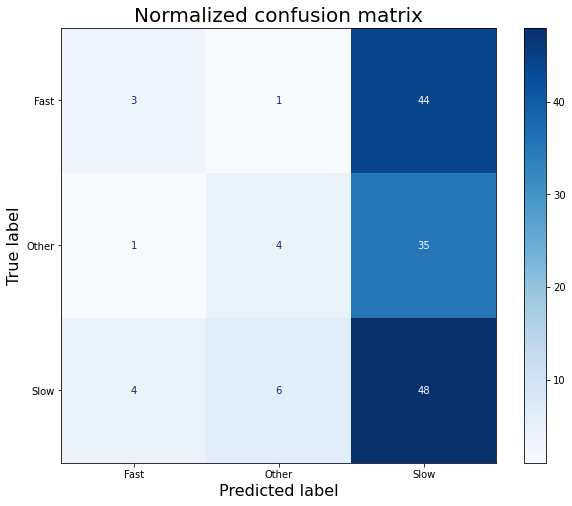

In [4]:
# Gaussian Process
model = GaussianProcessClassifier(random_state=1, n_jobs=-1)
acc, y_pred = train_and_test(model, X_train, y_train, X_test, y_test, precision=precision)
results_list.append(acc)
pred_list.append((y_pred, y_test))

if print_results:
    print_metrics(model, X_train, y_train, y_pred, X_test, y_test, class_names=class_names)

## Playing around with `GPytorch`

In [20]:
train_x = torch.from_numpy(X_train.to_numpy().astype(np.float32))
train_y = torch.from_numpy(y_train)

In [29]:
train_x.shape

torch.Size([460, 29])

In [32]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.mlls.variational_elbo import VariationalELBO


class GPClassificationModel(AbstractVariationalGP):
    
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(self, train_x, variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_classes=3, mixing_weights=False, num_features=3)

In [33]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, train_y.numel())

training_iter = 5
for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    print(output)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()


MultivariateNormal(loc: torch.Size([460]))


RuntimeError: There should be 3 features